In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%R
library(prophet)
library(dplyr)

## Sub-daily data

Prophet can make forecasts for time series with sub-daily observations by passing in a dataframe with timestamps in the `ds` column. The format of the timestamps should be YYYY-MM-DD HH:MM:SS - see the example csv [here](https://github.com/facebook/prophet/blob/master/examples/example_yosemite_temps.csv). When sub-daily data are used, daily seasonality will automatically be fit. Here we fit Prophet to data with 5-minute resolution (daily temperatures at Yosemite):

Initial log joint probability = -1444.46
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


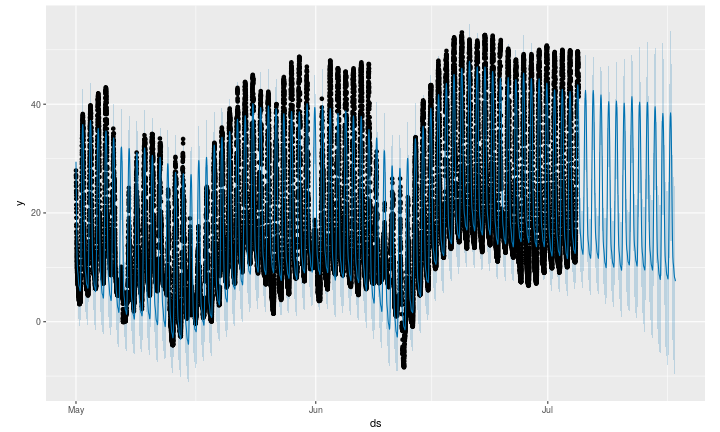

In [3]:
%%R -w 10 -h 6 -u in
df <- read.csv('../examples/example_yosemite_temps.csv')
m <- prophet(df, changepoint.prior.scale=0.01)
future <- make_future_dataframe(m, periods = 300, freq = 60 * 60)
fcst <- predict(m, future)
plot(m, fcst);

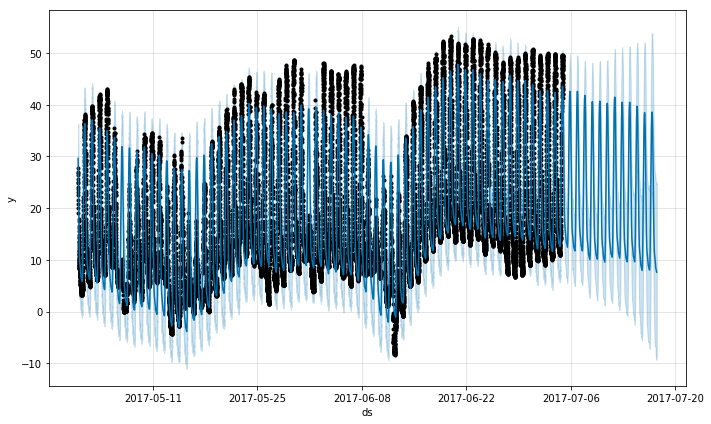

In [4]:
df = pd.read_csv('../examples/example_yosemite_temps.csv')
m = Prophet(changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
m.plot(fcst);

The daily seasonality will show up in the components plot:

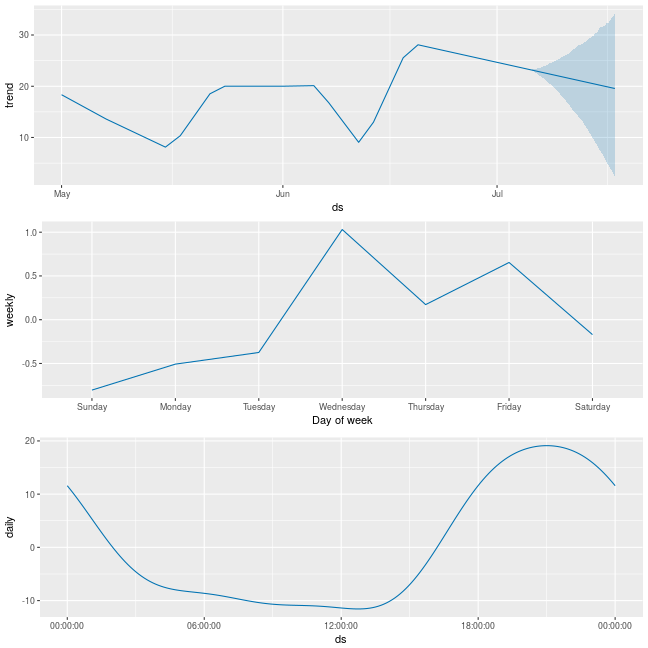

In [5]:
%%R -w 9 -h 9 -u in
prophet_plot_components(m, fcst)

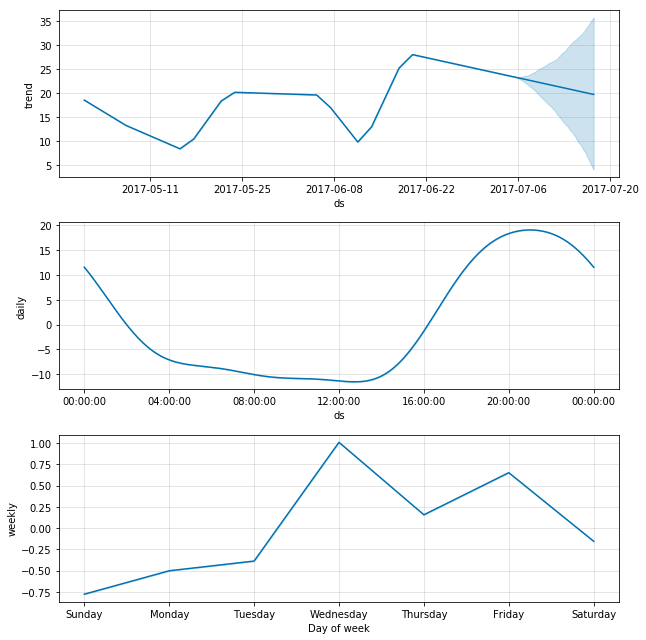

In [6]:
m.plot_components(fcst);

## Data with regular gaps

Suppose the dataset above only had observations from 12a to 6a:

Initial log joint probability = -467.044
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


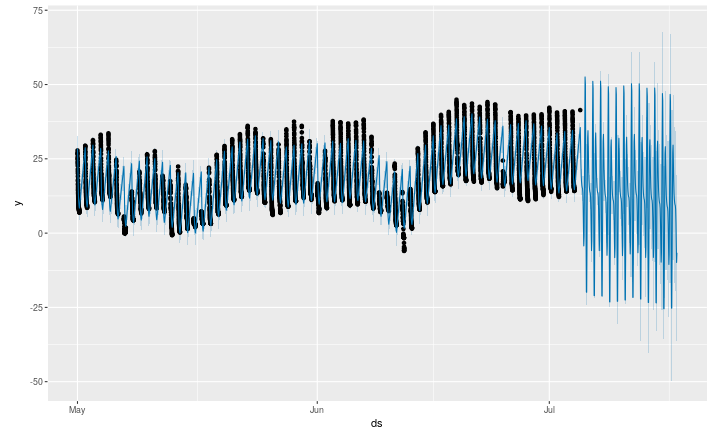

In [7]:
%%R -w 10 -h 6 -u in
df2 <- df %>%
  mutate(ds = as.POSIXct(ds, tz="GMT")) %>%
  filter(as.numeric(format(ds, "%H")) < 6)
m <- prophet(df2)
future <- make_future_dataframe(m, periods = 300, freq = 60 * 60)
fcst <- predict(m, future)
plot(m, fcst);

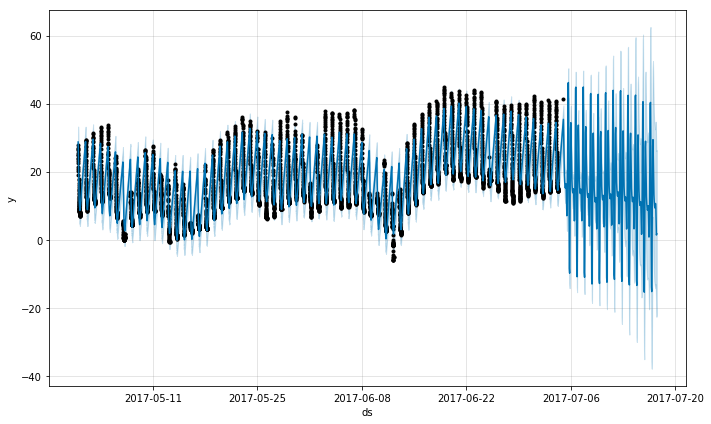

In [8]:
df2 = df.copy()
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2[df2['ds'].dt.hour < 6]
m = Prophet().fit(df2)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
m.plot(fcst);

The forecast seems quite poor, with much larger fluctuations in the future than were seen in the history. The issue here is that we have fit a daily cycle to a time series that only has data for part of the day (12a to 6a). The daily seasonality is thus unconstrained for the remainder of the day and is not estimated well. The solution is to only make predictions for the time windows for which there are historical data. Here, that means to limit the `future` dataframe to have times from 12a to 6a:

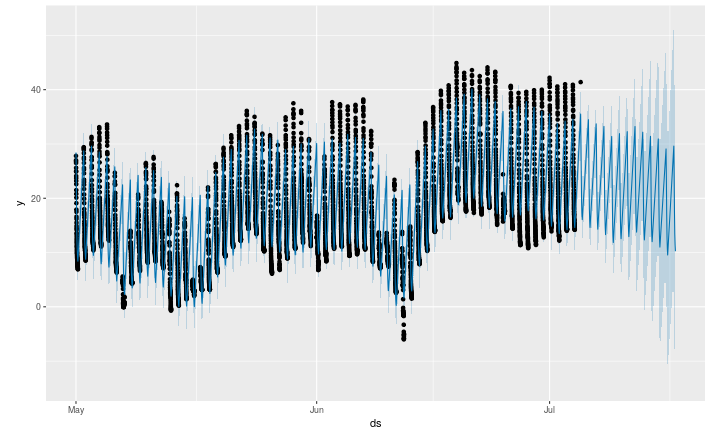

In [9]:
%%R -w 10 -h 6 -u in
future2 <- future %>% 
  filter(as.numeric(format(ds, "%H")) < 6)
fcst <- predict(m, future2)
plot(m, fcst);

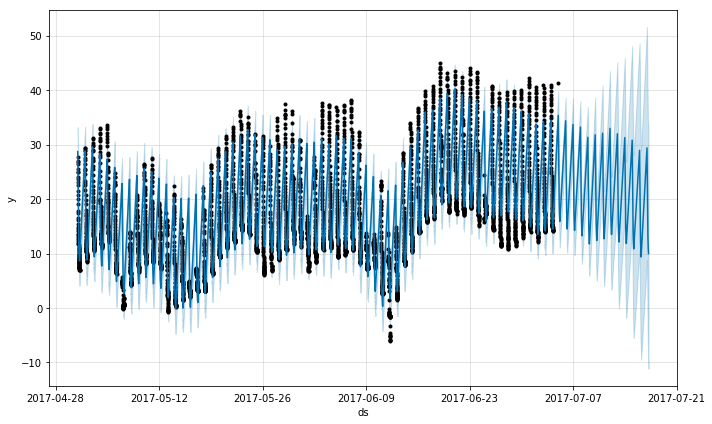

In [10]:
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour < 6]
fcst = m.predict(future2)
m.plot(fcst);

The same principle applies to other datasets with regular gaps in the data. For example, if the history contains only weekdays, then predictions should only be made for weekdays since the weekly seasonality will not be well estimated for the weekends.

## Monthly data

You can use Prophet to fit monthly data. However, the underlying model is continuous-time, which means that you can get strange results if you fit the model to monthly data and then ask for daily forecasts. Here we forecast US retail sales volume for the next 10 years:

Initial log joint probability = -2.41173
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


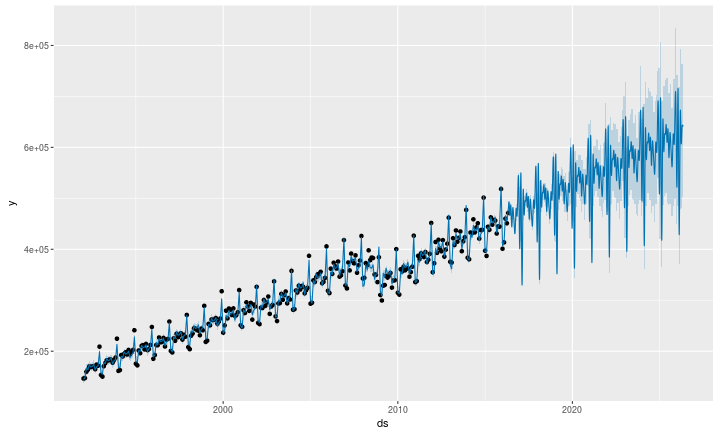

In [11]:
%%R -w 10 -h 6 -u in
df <- read.csv('../examples/example_retail_sales.csv')
m <- prophet(df, seasonality.mode = 'multiplicative')
future <- make_future_dataframe(m, periods = 3652)
fcst <- predict(m, future)
plot(m, fcst);

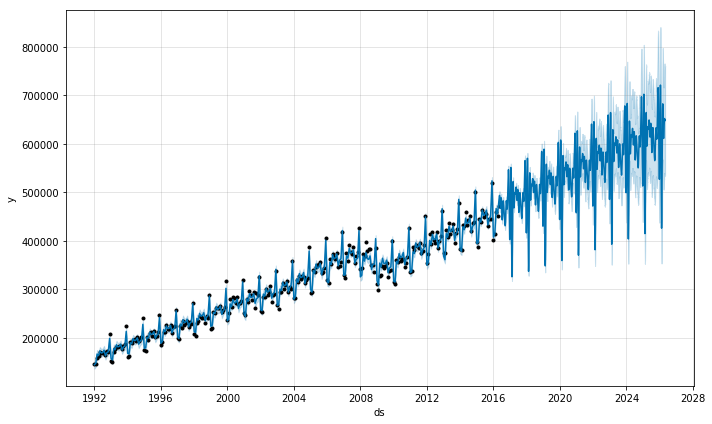

In [12]:
df = pd.read_csv('../examples/example_retail_sales.csv')
m = Prophet(seasonality_mode='multiplicative').fit(df)
future = m.make_future_dataframe(periods=3652)
fcst = m.predict(future)
m.plot(fcst);

This is the same issue from above where the dataset has regular gaps. When we fit the yearly seasonality, it only has data for the first of each month and the seasonality components for the remaining days are unidentifiable and overfit. This can be clearly seen by doing MCMC to see uncertainty in the seasonality:


SAMPLING FOR MODEL 'prophet' NOW (CHAIN 1).

Gradient evaluation took 0.000177 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.77 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)
Iteration: 210 / 300 [ 70%]  (Sampling)
Iteration: 240 / 300 [ 80%]  (Sampling)
Iteration: 270 / 300 [ 90%]  (Sampling)
Iteration: 300 / 300 [100%]  (Sampling)

 Elapsed Time: 7.64282 seconds (Warm-up)
               12.4094 seconds (Sampling)
               20.0522 seconds (Total)


SAMPLING FOR MODEL 'prophet' NOW (CHAIN 2).

Gradient evaluation took 9.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
Adjust your expectations accord

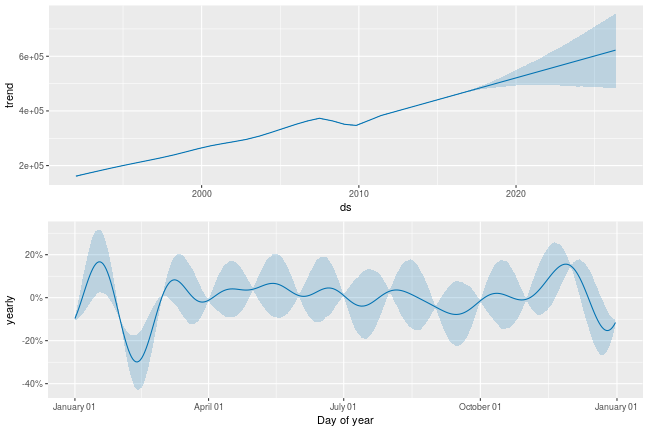

In [14]:
%%R -w 9 -h 6 -u in
m <- prophet(df, seasonality.mode = 'multiplicative', mcmc.samples = 300)
fcst <- predict(m, future)
prophet_plot_components(m, fcst)

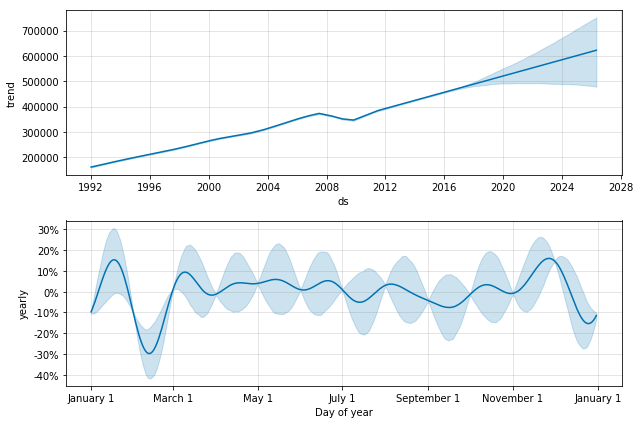

In [13]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(df)
fcst = m.predict(future)
m.plot_components(fcst);

The seasonality has low uncertainty at the start of each month where there are data points, but has very high posterior variance in between. When fitting Prophet to monthly data, only make monthly forecasts, which can be done by passing the frequency into make_future_dataframe:

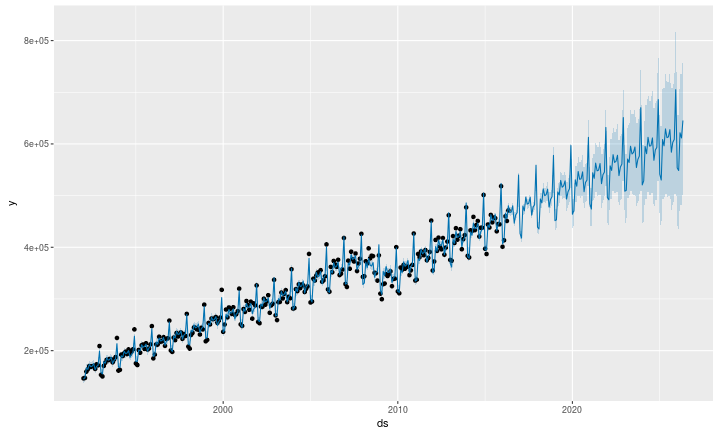

In [9]:
%%R -w 10 -h 6 -u in
future <- make_future_dataframe(m, periods = 120, freq = 'month')
fcst <- predict(m, future)
plot(m, fcst)

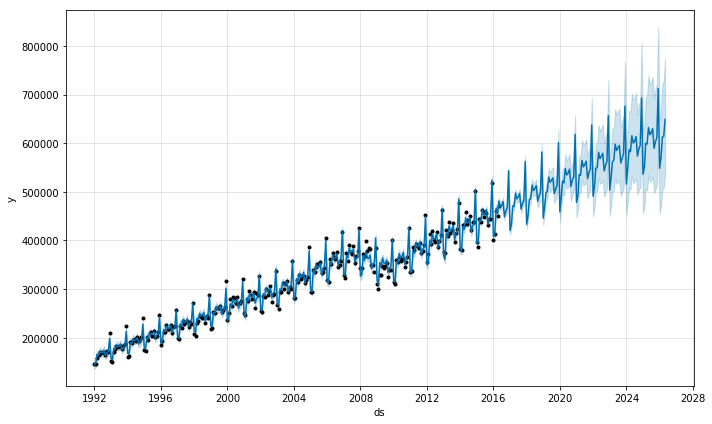

In [10]:
future = m.make_future_dataframe(periods=120, freq='M')
fcst = m.predict(future)
m.plot(fcst);